In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline

import pandas as pd
import numpy as np
from math import ceil

In [ ]:
import io
import requests
Content = requests.get("https://raw.githubusercontent.com/flmath-dirty/matrixes_in_erlang/master/results.cvs").content
LoadedTable= pd.read_csv(io.StringIO(Content.decode('utf-8')),skipinitialspace=True,
                  names=['Test type', 'Width', 'Height','Matrix representation','No. of calls', 'Execution time'])

The LoadedTable contains statistics gathered from running the script that generates a matrix (Width x Height) and then 
runs with the [fprof](http://erlang.org/doc/man/fprof.html) following tests for each representation of matrix and sizes:

The tests categories:

 - one_rows_sums - sum of values from each row in the matrix
 
 - one_cols_sums - sum of values from each row in the matrix
 
 - get_value - gets each value from the matrix once separetly
 
 - set_value - sets each value from the matrix once separetly 



Matrixes are represented as follow:
 - [sofs](http://erlang.org/doc/man/sofs.html): Set of the sets module is a way of representing relations (in strictly mathematical sense). In this case the matrix is represented as a relation (a function) F where domain is constructed from coordinates which is related to the matrix entry value ({x,y} F Value).
 
 To get values in specific row we define equivalence relation aRb iff thera are {x,y1} F a {x,y2} F b.
 This relation divides antidomain in abbstract classes. If we sum elements belonging to the abstract class with element {x,_} we will get sum of the elements from this specific row. We use the same logic to receive abstrac classes for columns.
 
 
 - [digraph](http://erlang.org/doc/man/digraph.html): We have a directed graph where each value is stored in vertex with the coordinate {x,y}. Aside of that each column and row has dedicated vertex with edges from corresponding coordinate vertexes directed at it to speed up rows and columns sums calculations.
 
 
 - [array](http://erlang.org/doc/man/array.html): The matrix is represented as a tuple {Width, Height, Array}, where the array has size Width * Height, all operations are done with simply calculating positions of the values in the array.
 
 
 - big tuple: The matrix is represented as a tuple {Width, Height, BigTuple} where the BigTuple is tuple used in the same way as the Array from previous point (note: arrays indexing starts from 0).
 
 
 - [map]{http://erlang.org/doc/man/maps.html): A quite fresh data structure in Erlang, we map coordinates {x,y} to values.
 
 
 - List of the lists: Each of sublists of the list contains elements representing  values in the row. Since it visually resembles a matrix, it is quite often abused by coders. Heavy usage of [lists]{http://erlang.org/doc/man/lists.html) module.

 I have run tests on the square matrixes of sizes 50x50, 100x100, 1000x1000. For some of the 1000x1000 tests fprof logs exceeded the dedicated 2TB disk size. For those the values are missing.

In [42]:
LoadedTable.head()

,Test type,Width,Height,Matrix representation,No. of calls,Execution time
0,one_rows_sums,50,50,matrix_as_sofs,20452,48.280
1,one_rows_sums,50,50,matrix_as_digraph,20531,59.981
2,one_rows_sums,50,50,matrix_as_array,18483,36.792
3,one_rows_sums,50,50,matrix_as_map,13684,42.790
4,one_rows_sums,50,50,matrix_as_big_tuple,5962,12.147


In [43]:
from scipy import stats
from functools import reduce
AggregatedTable = (LoadedTable.groupby(['Test type','Matrix representation'])['Execution time']
                   .apply(list).reset_index(name='Execution Times List'))

Create aggregate table with execution time values for different size of matrixes stored in one list.

In [44]:
AggregatedTable.head()

,Test type,Matrix representation,Execution Times List
0,get_value,matrix_as_array,"[59.462, 232.601, 28018.33]"
1,get_value,matrix_as_big_tuple,"[25.176, 121.824, 12527.693]"
2,get_value,matrix_as_digraph,"[42.854, 211.419, 19704.339]"
3,get_value,matrix_as_list_of_lists,"[280.91, 2073.251]"
4,get_value,matrix_as_map,"[36.883, 159.307, 15976.373]"


Each list should have 3 values, if one is missing it means it exceeded testing capability of my equipment, and can be considered infinite. Also add columns with minimum values, maximum values and harmonic averages (since standard average would be too susceptible to outliers here).

In [45]:
AggregatedTable['Harmonic Average'] = AggregatedTable['Execution Times List'].apply(
    lambda x: stats.hmean(x) if (len(x) == 3) else np.inf)

In [46]:
AggregatedTable['Max'] = AggregatedTable['Execution Times List'].apply(
    lambda x: max(x) if (len(x) == 3) else np.inf)

In [47]:
AggregatedTable['Min'] = AggregatedTable['Execution Times List'].apply(min)

In [48]:
AggregatedTable.head()

,Test type,Matrix representation,Execution Times List,Harmonic Average,Max,Min
0,get_value,matrix_as_array,"[59.462, 232.601, 28018.33]",141.828134,2.801833e+04,59.462
1,get_value,matrix_as_big_tuple,"[25.176, 121.824, 12527.693]",62.488602,1.252769e+04,25.176
2,get_value,matrix_as_digraph,"[42.854, 211.419, 19704.339]",106.701803,1.970434e+04,42.854
3,get_value,matrix_as_list_of_lists,"[280.91, 2073.251]",inf,inf,280.910
4,get_value,matrix_as_map,"[36.883, 159.307, 15976.373]",89.679282,1.597637e+04,36.883


 Lets compare execution times for retrieving values.

In [49]:
GetValue = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='get_value']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

GetValue = GetValue.set_index('Matrix representation')

In [50]:
from jupyter_extensions.matplotlib.sawed_bar_plot import sawed_bar_plot

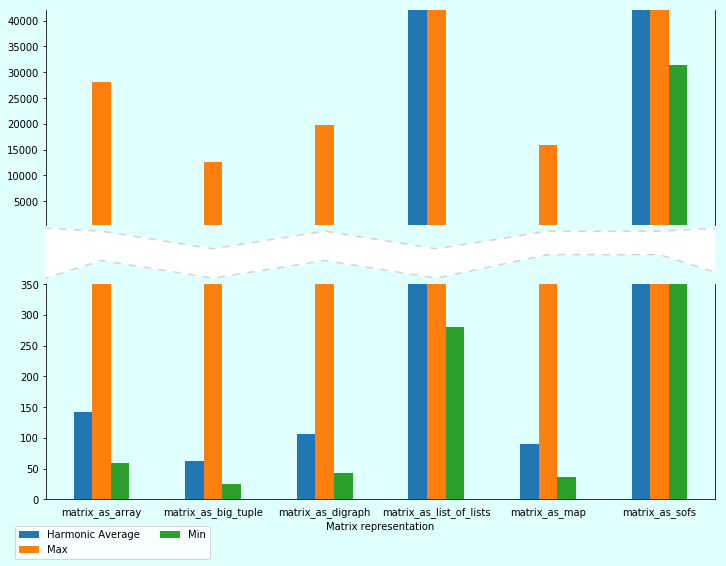

In [51]:
sawed_bar_plot(GetValue)

It occurs that lists of the list and set of sets implementation is extremely inefficient at retrieving values. 

The list of the lists sounds obvious since to get element in the middle we need to traverse to middle list representing row and then again in the row traverse to the middle element which gives O(n^2) access time.

The sofs occurs to be a trap, if you will read documentation you will see elegant (from mathematician point of view) relation algebra. But if you go inside the source code you will find that module extensively uses lists:fold which translates implementation to the list of lists scenario in the best case. We can probaly make the first conclusion and an advice here: Don't abuse sofs, remember map is actually relation too (precisely function, but noone can forbid you from returning lists or other containers). 

Other implementations look resonable. The are some suprises, like the better perfomance of big tuples than arrays.

Let see set_value functions perfomances.

In [52]:
SetValue = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='set_value']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )
SetValue = SetValue.set_index('Matrix representation')

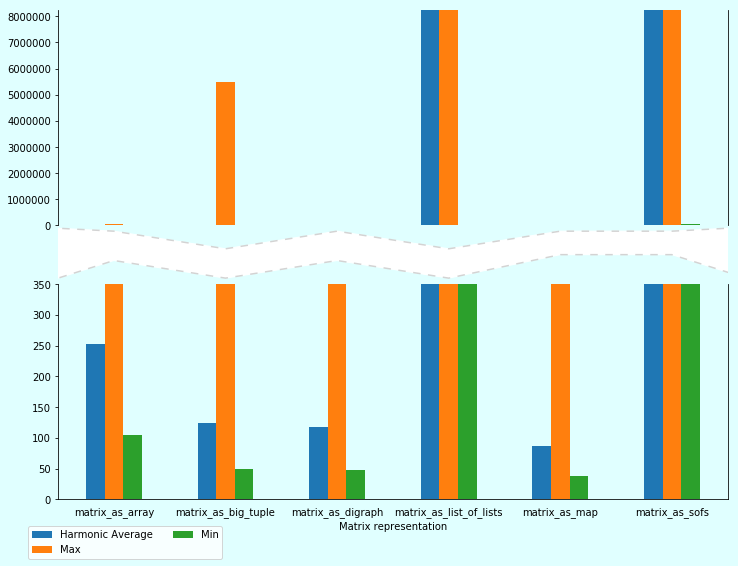

In [53]:
sawed_bar_plot(SetValue)

The lists of lists amd softs are outclassed even for small matrixes like 10x10.

As we suspected the big_tuple is much worse at setting values since it is immutable and setting one value means copying whole tuple. We can notice that the array even if it is more efficient has some values above the rift, lets change a little perspective:

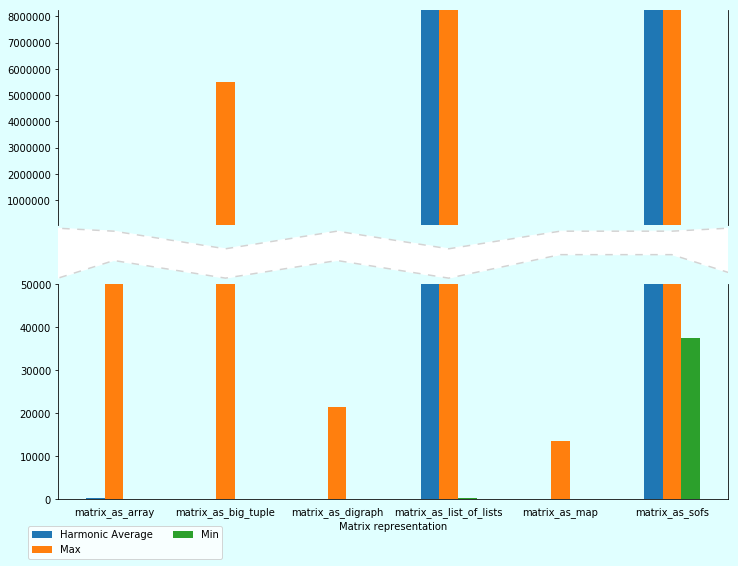

In [54]:
sawed_bar_plot(SetValue,50000)

The array is much better than tuple, but both are magnitude worse than directed graph and matrix. It is now worth mentioning that digraph are implemented as an ets table which suggest a fixed overhead at first, but good efficiency for big tables. Still implementation with maps (build in ERTS) is faster even for 1000x1000 matrixes. We will investigate execution times increse further in the document.

Since digraph represented as an ets database is quite efficient is worth to ask and keep in mind a question: if we can craft matrix representation with ets table that will be more efficient than map. I will come back to this question at the end of this document.

The need for this small research occured during implemetation of a statistics gathering module. It was important to be able to calculate sums of specific counters. Usually in that case the best way is to make interface to some c or python application which support fast calculating. But this increases the complexity of the product, which should be usually avoided. Let check a performance of columns summation.

In [162]:
OneColsSums = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='one_cols_sums']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

OneColsSums = OneColsSums.set_index('Matrix representation')

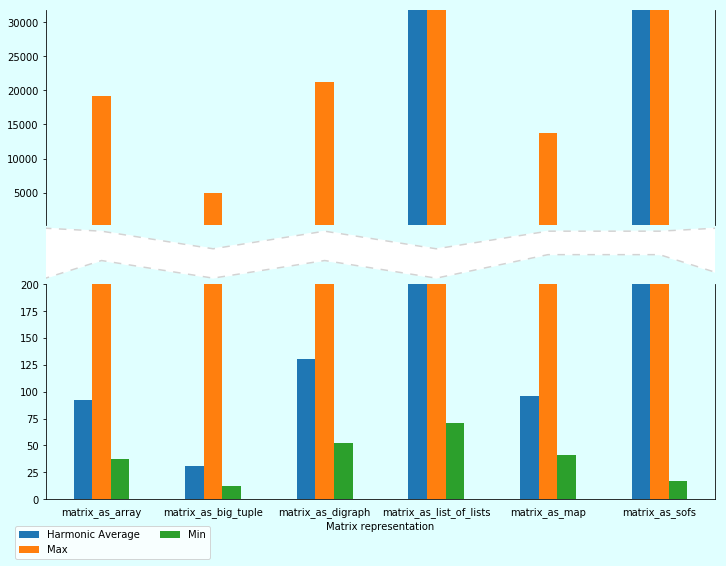

In [163]:
sawed_bar_plot(OneColsSums,200)

It is very confusing result, both array and tuple calculates the needed n indexes (in very C style) and sum extracted values (should be o(n^2), n calculations times n columns to calculate), still array is slower for big numbers than map which has to try to find value with hash (o(log(n)*n^2)), suggesting some inefficiency in implementation.

Lets look at summing rows:

In [164]:
OneRowsSums = (
    AggregatedTable
    .loc[AggregatedTable['Test type']=='one_rows_sums']
    .loc[:,['Matrix representation','Harmonic Average','Max','Min']]
    )

OneRowsSums = OneRowsSums.set_index('Matrix representation')

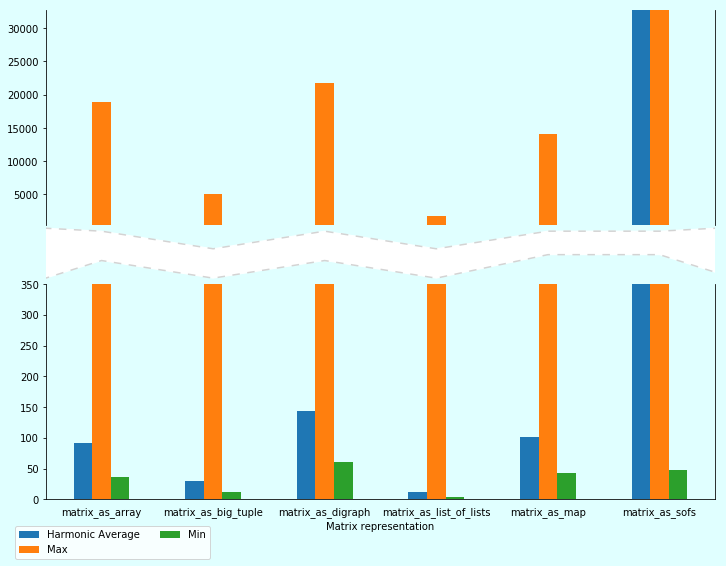

In [165]:
sawed_bar_plot(OneRowsSums)

Results are similar to the previous, with exception of the list of the list, which has obvious advantage since the dominating operation is summation of the list implemented as linked lists. Anyway since setting a value is extremly expensive, this implementation is still not really good.

Lets remove the sofs and the lists of lists from further considerations.

The next thing we should consider is which implementation is the best for small matrixes.

In [166]:
AggregatedTableRestricted = AggregatedTable[
            (AggregatedTable['Matrix representation']!='matrix_as_list_of_lists') &
            (AggregatedTable['Matrix representation']!='matrix_as_sofs')]
AggregatedTableRestricted.head()

,Test type,Matrix representation,Execution Times List,Harmonic Average,Max,Min
0,get_value,matrix_as_array,"[59.462, 232.601, 28018.33]",141.828134,28018.330,59.462
1,get_value,matrix_as_big_tuple,"[25.176, 121.824, 12527.693]",62.488602,12527.693,25.176
2,get_value,matrix_as_digraph,"[42.854, 211.419, 19704.339]",106.701803,19704.339,42.854
4,get_value,matrix_as_map,"[36.883, 159.307, 15976.373]",89.679282,15976.373,36.883
6,one_cols_sums,matrix_as_array,"[37.541, 176.126, 19173.0]",92.685699,19173.000,37.541


In [214]:
Minimums = (
    AggregatedTableRestricted  
    .loc[:,['Test type','Matrix representation','Min']]
    )
#Minimums.groupby(['Test type','Matrix representation'])
Minimums = Minimums.set_index(['Test type','Matrix representation'])
Minimums.head()

Min
Test type     Matrix representation        
get_value     matrix_as_array        59.462
              matrix_as_big_tuple    25.176
              matrix_as_digraph      42.854
              matrix_as_map          36.883
one_cols_sums matrix_as_array        37.541

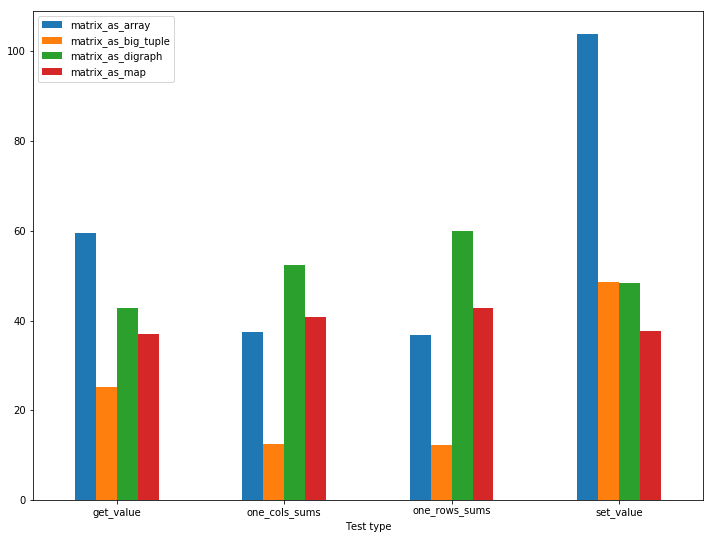

In [216]:
TestTypes = Minimums.index.get_level_values('Test type').unique().tolist()
#MatrixRepresentations = Minimums.index.get_level_values('Matrix representation').unique().tolist()
Plot = Minimums.unstack().plot(kind='bar',figsize=(12,9))
Plot.set_xticklabels(TestTypes,rotation="horizontal")
handles, labels=Plot.get_legend_handles_labels()
labels = [Label[6:-1] for Label in labels]
Plot.legend(handles,labels)
plt.show()